In [1]:
import pandas as pd
import numpy as np
import plotly.express as px 
import plotly.graph_objects as go 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [29]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("XYZCorp_LendingData.txt", sep = "\t", low_memory = False)

In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df.isna().sum()/len(df))

id                             0.000000
member_id                      0.000000
loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      0.057763
emp_length                     0.050307
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
pymnt_plan                     0.000000
desc                           0.857691
purpose                        0.000000
title                          0.000039
zip_code                       0.000000
addr_state                     0.000000
dti                            0.000000
delinq_2yrs                    0.000000
earliest_cr_line               0.000000


In [15]:
missing_count = df.isna().sum()/len(df)

In [16]:
df_clean = df.copy()
for col in df.columns:
    if missing_count[col] > 0.9:
        df_clean = df_clean.drop(col, axis = 1)

In [17]:
df_clean = df_clean.drop(["desc"], axis = 1)

In [ ]:
df_clean.shape

In [13]:
[x for x in df.columns if x not in df_clean.columns]

['desc',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [212]:
df_clean["next_pymnt_d"].value_counts()

Feb-2016    534094
Jan-2016     68838
Mar-2016        66
Name: next_pymnt_d, dtype: int64

In [18]:
si = SimpleImputer(strategy = "most_frequent")
df_clean["next_pymnt_d"] = si.fit_transform(df_clean["next_pymnt_d"].to_numpy().reshape(-1,1))

In [19]:
df_clean["next_pymnt_d"]

0         Feb-2016
1         Feb-2016
2         Feb-2016
3         Feb-2016
4         Feb-2016
            ...   
855964    Feb-2016
855965    Feb-2016
855966    Feb-2016
855967    Feb-2016
855968    Feb-2016
Name: next_pymnt_d, Length: 855969, dtype: object

Large variation in employment length and form EDA know 10+ years decreases likeklihood of defaulting, so not worth imputing.

No meaningful way to guess employment, enough data with the info to drop missing values

Small amount of info missing for last payment day and for revol_util, not worth imputing 

In [20]:
si_999 = SimpleImputer(strategy = "constant", fill_value = 999)
df_clean["mths_since_last_delinq"] = si_999.fit_transform(df_clean["mths_since_last_delinq"].to_numpy().reshape(-1,1))
df_clean["mths_since_last_record"] = si_999.fit_transform(df_clean["mths_since_last_record"].to_numpy().reshape(-1,1))
df_clean["mths_since_last_major_derog"] = si_999.fit_transform(df_clean["mths_since_last_major_derog"].to_numpy().reshape(-1,1))

#assumption made here that if not populated, they aren't applicable. i.e. there have been no delinquencies for the person
#Filling with 999 to indicate this

In [216]:
df_clean.shape[0]/df.shape[0]

1.0

In [217]:
df[df["revol_util"].isna()]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind
3563,1016416,1244120,8000.0,8000.0,8000.0,36 months,19.42,294.95,E,E3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4712,997734,1222858,6100.0,6100.0,6100.0,36 months,14.27,209.29,C,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4942,790093,994164,7200.0,7200.0,7200.0,36 months,14.27,247.03,C,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
11269,817195,1024992,5000.0,5000.0,5000.0,36 months,21.36,189.31,F,F4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
12026,804073,1009899,3000.0,3000.0,3000.0,60 months,22.11,83.05,G,G1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841406,38548365,41332242,17275.0,17275.0,17275.0,60 months,16.49,424.61,D,D3,...,NaN,NaN,NaN,NaN,NaN,4500.0,NaN,NaN,NaN,0
851788,38262179,41045939,35000.0,35000.0,35000.0,36 months,13.66,1190.45,C,C3,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
851857,38282621,41066402,3350.0,3350.0,3350.0,36 months,9.49,107.30,B,B2,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
851923,38342391,41126161,9500.0,9500.0,9500.0,36 months,8.67,300.65,B,B1,...,NaN,NaN,NaN,NaN,NaN,90000.0,NaN,NaN,NaN,0


In [218]:
identical = df_clean["loan_amnt"] == df_clean["funded_amnt"]

In [219]:
df_clean[~identical]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_ind
61,1068934,1277395,17500.0,8950.0,8925.0,60 months,17.27,223.74,D,D3,...,Jan-2016,0.0,999.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
66,1069093,1303740,12500.0,8925.0,8925.0,60 months,17.27,223.11,D,D3,...,Jan-2016,0.0,999.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1
70,1069043,1303486,20975.0,13575.0,13550.0,60 months,17.58,341.63,D,D4,...,Apr-2014,0.0,999.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
77,1068416,1302799,7250.0,7200.0,7175.0,60 months,21.67,197.51,F,F3,...,Jan-2016,0.0,999.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
80,1068994,1303432,35000.0,22075.0,22050.0,60 months,17.27,551.84,D,D3,...,Feb-2014,0.0,999.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224394,1042487,1272771,20000.0,13675.0,6675.0,60 months,19.91,361.62,E,E4,...,Aug-2014,0.0,999.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
224396,1063649,1296212,17500.0,16800.0,16775.0,60 months,22.74,471.10,G,G1,...,Jan-2016,0.0,999.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1
224397,1062754,1295040,35000.0,22550.0,22550.0,60 months,14.27,527.87,C,C2,...,Jan-2016,0.0,999.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1
224400,1062334,1294400,20000.0,12675.0,12675.0,60 months,14.27,296.71,C,C2,...,Jan-2016,0.0,999.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0


Only 7 cases where the funded amount is equal to the loan amount, otherwise identical. Therefore dropping funded amount

In [21]:
df_clean = df_clean.drop(["funded_amnt"], axis = 1)

In [22]:
df_clean["funded_amnt_inv_perc"] = df_clean["funded_amnt_inv"]/df_clean["loan_amnt"]
df_clean = df_clean.drop(["funded_amnt_inv"],axis = 1)

In [23]:
east = ['CT','MA','ME','NH','NJ','NY','PA','RI','VT']
midwest = ['IA','IL','IN','KS','MI','MN','MO','ND','NE','OH','SD','WI']
south = ['AL','AR','DC','DE','FL','GA','KY','LA','MD','MS','NC','OK','SC','TN','TX','VA','WV']
west = ['AK','AZ','CA','CO','HI','ID','MT','NM','NV','OR','UT','WA','WY']
df_clean["region"] = df_clean["addr_state"].apply(lambda x: "East" if x in east else
                                       ("Midwest" if x in midwest else
                                        ("South" if x in south else
                                         ("West" if x in west else np.nan))))
#Adding region field to avoid having 50+ features just for location after OHE 

In [24]:
df_clean = df_clean.drop(["emp_title","title","zip_code","addr_state"],axis = 1)
#dropping text-based columns remaining
df_clean["term"] = df_clean["term"].apply(lambda x:x.strip().split(" ")[0])
#removing the months part from term, leaving only an integer
df_clean = df_clean.drop(["pymnt_plan"], axis = 1)
#dropping pymnt_plan as only 5 values have a 'y' value, so not adding any information
df_clean = df_clean.dropna()
df_clean["emp_length"] = df_clean["emp_length"].replace({"10+ years":"10","< 1 year":"0"}).apply(lambda x:int(x.strip().split()[0]))
#Change emp_length to be numerical, with values 0-10
df_clean["purpose"] = df_clean["purpose"].replace({"educational":"other"})
#only one value with educational, so classifying as other to prevent extra OHE col
df_clean = df_clean.drop(["member_id","id"], axis = 1)
#ids don't provide any info on the general patterns since each one is unique

In [224]:
df_clean["purpose"].value_counts()

debt_consolidation    444107
credit_card           177312
home_improvement       41754
other                  32310
major_purchase         12642
small_business          6728
medical                 6520
car                     6055
moving                  4027
vacation                3640
house                   2705
wedding                  849
renewable_energy         386
Name: purpose, dtype: int64

In [225]:
df_clean.iloc[0]

loan_amnt                                 27050.0
term                                           36
int_rate                                    10.99
installment                                885.46
grade                                           B
sub_grade                                      B2
emp_length                                     10
home_ownership                                OWN
annual_inc                                55000.0
verification_status                      Verified
issue_d                                  Dec-2013
purpose                        debt_consolidation
dti                                         22.87
delinq_2yrs                                   0.0
earliest_cr_line                         Oct-1986
inq_last_6mths                                0.0
mths_since_last_delinq                      999.0
mths_since_last_record                      999.0
open_acc                                     14.0
pub_rec                                       0.0


In [226]:
df_clean.corr()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_ind,funded_amnt_inv_perc
loan_amnt,1.000000,0.129050,0.943675,0.095892,0.328936,0.031679,-0.007889,-0.028115,0.024389,0.118609,...,0.222767,-0.020866,0.079080,NaN,0.001047,-0.004034,0.323572,0.308720,0.002965,0.000989
int_rate,0.129050,1.000000,0.114734,0.005745,-0.084599,0.158645,0.048920,0.243064,-0.067048,-0.062367,...,0.106714,0.012033,-0.073869,NaN,0.026791,0.001210,-0.091860,-0.161537,0.161952,-0.024836
installment,0.943675,0.114734,1.000000,0.080577,0.323165,0.015327,0.000344,0.005860,0.011921,0.106060,...,0.236338,-0.018111,0.064683,NaN,0.004003,-0.003326,0.292995,0.283884,0.015615,-0.000969
emp_length,0.095892,0.005745,0.080577,1.000000,0.058873,0.033447,0.022319,-0.003604,-0.047193,-0.034484,...,0.027998,-0.006183,-0.029921,NaN,0.007990,-0.000630,0.097218,0.075622,-0.009705,0.002035
annual_inc,0.328936,-0.084599,0.323165,0.058873,1.000000,-0.187205,0.045224,0.038548,-0.052562,0.027464,...,0.085897,-0.004744,-0.014510,NaN,0.014855,0.001112,0.418504,0.269619,-0.032381,0.010660
dti,0.031679,0.158645,0.015327,0.033447,-0.187205,1.000000,-0.015748,-0.006468,0.039144,0.064978,...,-0.056438,-0.004131,0.059611,NaN,0.004964,-0.004285,-0.010831,0.071941,0.025117,-0.022129
delinq_2yrs,-0.007889,0.048920,0.000344,0.022319,0.045224,-0.015748,1.000000,0.026194,-0.377629,0.020785,...,-0.018162,0.062824,-0.250208,NaN,0.131658,0.000234,0.063048,-0.041551,-0.004496,-0.000081
inq_last_6mths,-0.028115,0.243064,0.005860,-0.003604,0.038548,-0.006468,0.026194,1.000000,-0.037476,-0.083412,...,0.066539,0.009346,-0.081912,NaN,-0.004570,0.003006,0.035044,0.006639,0.069409,0.008125
mths_since_last_delinq,0.024389,-0.067048,0.011921,-0.047193,-0.052562,0.039144,-0.377629,-0.037476,1.000000,0.015551,...,0.018020,-0.051441,0.557079,NaN,-0.071132,-0.012661,-0.056421,0.088357,0.012950,0.002548
mths_since_last_record,0.118609,-0.062367,0.106060,-0.034484,0.027464,0.064978,0.020785,-0.083412,0.015551,1.000000,...,0.029813,-0.021370,0.091074,NaN,0.003029,-0.005983,0.092595,0.124837,0.014289,-0.017059


In [230]:
df_test = df_clean.copy()
df_test["next_pymnt_d"].iloc[39698]

'Feb-2016'

In [25]:
df_clean.astype({'term': 'int64'}).dtypes
df_clean[["issue_d","earliest_cr_line","last_pymnt_d","last_credit_pull_d"]] = pd.to_datetime(df[["issue_d","earliest_cr_line","last_pymnt_d","last_credit_pull_d"]].stack()).unstack()


df_clean["next_pymnt_d"] = pd.to_datetime(df_clean["next_pymnt_d"])

X_train = df_clean[df_clean["issue_d"] <= "31-05-2015"].drop(['issue_d',"default_ind"], axis = 1)
X_test = df_clean[df_clean["issue_d"] > "31-05-2015"].drop(['issue_d',"default_ind"], axis = 1)

X_train[["earliest_cr_line","last_pymnt_d","next_pymnt_d","last_credit_pull_d"]]= X_train[["earliest_cr_line","last_pymnt_d","next_pymnt_d","last_credit_pull_d"]].stack().dt.to_period('M').astype(np.int64).unstack()
X_test[["earliest_cr_line","last_pymnt_d","next_pymnt_d","last_credit_pull_d"]]=X_test[["earliest_cr_line","last_pymnt_d","next_pymnt_d","last_credit_pull_d"]].stack().dt.to_period('M').astype(np.int64).unstack()
y_train = df_clean[df_clean["issue_d"] <= "31-05-2015"]["default_ind"]
y_test = df_clean[df_clean["issue_d"] > "31-05-2015"]["default_ind"]

C:\Users\JSKZ\.conda\envs\test\lib\site-packages\pandas\core\arraylike.py:52: UserWarning: Parsing '31-05-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.le)
C:\Users\JSKZ\.conda\envs\test\lib\site-packages\pandas\core\arraylike.py:56: UserWarning: Parsing '31-05-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.gt)
C:\Users\JSKZ\.conda\envs\test\lib\site-packages\pandas\core\arraylike.py:52: UserWarning: Parsing '31-05-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.le)
C:\Users\JSKZ\.conda\envs\test\lib\site-packages\pandas\core\arraylike.py:56: UserWarning: Parsing '31-05-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp

In [30]:
categorical_encoder = OneHotEncoder(handle_unknown = "ignore")
categorical_features = ["home_ownership","grade","verification_status","purpose","initial_list_status","application_type","region"]
numerical_features = df_clean.select_dtypes(exclude=['object']).columns.tolist()
numerical_features.remove("default_ind")
numerical_features.remove("issue_d")
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers = [
        ("cat", categorical_encoder,categorical_features),
        ("num",scaler,numerical_features)
    ], sparse_threshold = 0)


In [31]:
preprocessor

ColumnTransformer(sparse_threshold=0,
                  transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['home_ownership', 'grade',
                                  'verification_status', 'purpose',
                                  'initial_list_status', 'application_type',
                                  'region']),
                                ('num', StandardScaler(),
                                 ['loan_amnt', 'int_rate', 'installment',
                                  'emp_length', 'annual_inc', 'dti',
                                  'delinq_2yrs', 'earliest_cr_line',
                                  'inq_last_6mths'...delinq',
                                  'mths_since_last_record', 'open_acc',
                                  'pub_rec', 'revol_bal', 'revol_util',
                                  'total_acc', 'out_prncp', 'out_prncp_inv',
                                  'total_pymnt', 'total_pymnt_inv',
                                  'total_rec_prncp', 'total_rec_int',
                                  'total_rec_late_fee', 'recoveries',
                                  'collection_recovery_fee', 'last_pymnt_d',
                                  'last_pymnt_amnt', 'next_pymnt_d',
                                  'last_credit_pull_d',
                                  'collections_12_mths_ex_med', ...])])

In [32]:
X_train2 = X_train.copy()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [239]:
preprocessor.get_feature_names_out()

array(['cat__home_ownership_ANY', 'cat__home_ownership_MORTGAGE',
       'cat__home_ownership_NONE', 'cat__home_ownership_OTHER',
       'cat__home_ownership_OWN', 'cat__home_ownership_RENT',
       'cat__grade_A', 'cat__grade_B', 'cat__grade_C', 'cat__grade_D',
       'cat__grade_E', 'cat__grade_F', 'cat__grade_G',
       'cat__verification_status_Not Verified',
       'cat__verification_status_Source Verified',
       'cat__verification_status_Verified', 'cat__purpose_car',
       'cat__purpose_credit_card', 'cat__purpose_debt_consolidation',
       'cat__purpose_home_improvement', 'cat__purpose_house',
       'cat__purpose_major_purchase', 'cat__purpose_medical',
       'cat__purpose_moving', 'cat__purpose_other',
       'cat__purpose_renewable_energy', 'cat__purpose_small_business',
       'cat__purpose_vacation', 'cat__purpose_wedding',
       'cat__initial_list_status_f', 'cat__initial_list_status_w',
       'cat__application_type_INDIVIDUAL', 'cat__region_East',
       'cat__reg

In [ ]:
import sigopt
from sigopt import Connection
 
# put your token here
api_token = "RNSRLRHXYIOZZCZEFQAZQKZBMXWQVSEBLBWZTPOCMLFJMFIU"
 
conn = Connection(client_token=api_token)

In [260]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
accuracy_score(y_test,clf.predict(X_test))


0.9849365806978045

In [261]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(precision_score(y_test,clf.predict(X_test)))
print(recall_score(y_test,clf.predict(X_test)))
print(f1_score(y_test,clf.predict(X_test)))


0.057738572574178026
0.9953917050691244
0.10914603335017685


In [52]:
import xgboost as xgb
dtrain = xgb.DMatrix(data = X_train, label = y_train, feature_names =preprocessor.get_feature_names_out())
dtest = xgb.DMatrix(data = X_test, label = y_test, feature_names = preprocessor.get_feature_names_out())
xclf = xgb.XGBClassifier()
X_train = pd.DataFrame(X_train, columns = preprocessor.get_feature_names_out())
xclf.fit(X_train, y_train)
accuracy_score(y_test,xclf.predict(X_test))

0.9999957279015025

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(precision_score(y_test,xclf.predict(X_test)))
print(recall_score(y_test,xclf.predict(X_test)))
print(f1_score(y_test,xclf.predict(X_test)))


1.0
0.9953917050691244
0.997690531177829


In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test,xclf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    233860
           1       1.00      1.00      1.00       217

    accuracy                           1.00    234077
   macro avg       1.00      1.00      1.00    234077
weighted avg       1.00      1.00      1.00    234077



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

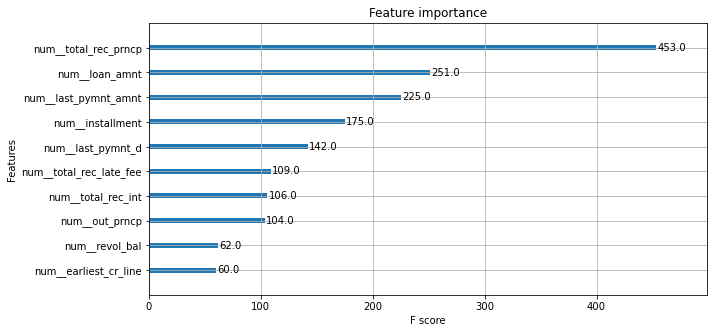

In [61]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs, max_num_features=10)
my_plot_importance(xclf, (10,5))

In [73]:
feature_important = xclf.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
top_10 = data.nlargest(10, columns="score")

fig = px.bar(top_10, orientation = "h", template = "plotly_white")
fig.update_layout(title = "Top 10 Features by Weight",
                 xaxis_title = "F Score",
                 yaxis_title = "Features",
                 showlegend = False)
fig.show()
fig.write_image("xgbc_feature_importance.png")

In [76]:
xclf.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [77]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve
precision, recall, thresholds = precision_recall_curve(y_test, xclf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xclf.predict(X_test))
fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()
fig.write_image("xclf_precision_recall.png")

In [37]:
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [79]:
y_test.sum()

217

In [78]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, xclf.predict(X_test))

array([[233860,      0],
       [     1,    216]], dtype=int64)

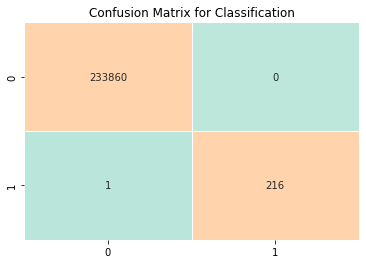

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
confusiondata = confusion_matrix(y_test, xclf.predict(X_test))
yticklabels = ["Positive", "Negative"]
xticklabels = ["Positive", "Negative"]
ax = plt.axes()
fig = sns.heatmap(confusiondata,linewidths=.5, annot=True, ax=ax, vmin = 0, vmax = 200,cmap="icefire",cbar = False,fmt='g')
ax.set_title("Confusion Matrix for Classification")
figure = fig.get_figure()    

figure.savefig("ConfusionMatrix.png") 

In [ ]:
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.model_selection import KFold, cross_validate
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
predictions = cross_validate(RandomForestClassifier(),X_train, y_train, cv = kf, scoring = ["accuracy","precision","recall","f1"])

In [273]:

predictions_xgb = xgb.cv(params = {}, dtrain = dtrain, nfold = 5, folds = kf, metrics = ["aucpr"])

In [275]:
predictions_xgb

,train-aucpr-mean,train-aucpr-std,test-aucpr-mean,test-aucpr-std
0,0.988107,0.000653,0.987411,0.000617
1,0.991321,0.000805,0.990593,0.000762
2,0.994485,0.000188,0.993904,0.000626
3,0.995383,0.000134,0.994822,0.000558
4,0.996204,0.000215,0.995532,0.000507
5,0.996772,0.000162,0.996122,0.000587
6,0.997394,0.000199,0.996791,0.000345
7,0.997873,0.000240,0.997256,0.000355
8,0.998219,0.000200,0.997713,0.000561
9,0.998387,0.000216,0.997855,0.000554


In [276]:
import pickle
with open('xgb_classifier_pkl', 'wb') as files:
    pickle.dump(xclf, files)


In [280]:
with open('X.pkl', "wb") as files:
    pickle.dump([X_train, X_test], files)
with open('y.pkl', "wb") as files:
    pickle.dump([y_train, y_test], files)

In [281]:
with open("feature_names.pkl", "wb") as files:
    pickle.dump(preprocessor.get_feature_names_out(), files)

In [259]:
df_clean[df_clean["issue_d"] <= "31-05-2015"][["loan_amnt","issue_d"]].max()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:52: UserWarning: Parsing '31-05-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.le)


loan_amnt                35000.0
issue_d      2015-05-01 00:00:00
dtype: object

In [282]:
df_clean.to_pickle("df_clean.pkl")